<a href="https://colab.research.google.com/github/popgenDK/evalPopStructure/blob/main/evalPCA_step_by_step_example_with_Chen%26Storey_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Load function for plotting


In [ ]:
#function plotCorRres for plotting correlations
source("https://raw.githubusercontent.com/GenisGE/evalAdmix/master/visFuns.R")

#load genetic test data
load(url("http://pontus.popgen.dk/albrecht/open/admixTjeck/data.Rdata"))


## summaries data



In [ ]:
cat("\ngenotype matrix\n")
dim(geno)

#transpose genotype
g <- t(geno)

cat("\nNumber of Individuals\n")
(N <- nrow(geno))

cat("\nNumber of SNPs\n")
( M <- ncol(geno))

cat("\n number of individual in each population\n")
pop <- as.factor(pop)
table(pop)


genotype matrix


[1]   374 54048


Number of Individuals


[1] 374


Number of SNPs


[1] 54048


 number of individual in each population


pop
CEU CHB MXL YRI 
 99 103  64 108 

# PCA1 method. Chen and Storey 



This appraoch has no centering or scaling of genotypes. $G$ is the MxN genotype matrix with M markers(SNPs) and N individual. Each genotype is arbitrarily coded according the major and minor allele
$G_{si}\in\{0,1,2\}$. The Chen and Storey approach first calculates a coveriance matrix and then subtracts the average heterozygosities of each individual
$$\widehat H= \frac1MG^TG-\widehat D,  \qquad \widehat D_{ii}= \frac1M\sum_{s=1}^M G_{si}(2-G_{si})$$

The PCA is then performed using eigen decomposition of this matrix
$$ \widehat H = UΣU^T$$






In [ ]:
# average heterozygosity per indivdual
d_hat <- colMeans(g * (2 - g)) 

# diagonal matrix of d_hat
D_hat <- diag(d_hat) 

#covariance matrix with
H_hat <- 1 / M * (t(g) %*% g) - D_hat

#perform decomposition of covariance matrix
e <- eigen(H_hat)


## plot the results

In the below plot the  first eigenvectors U_{1}$ and two next, $U_{2:3}$, are plottet 

Due to the manipulation of the diagonal this approach leads to the first PC having a different interpretation while the subsequent PCs will model the population structure. In the following we use +1 to indicate this such that PC1 +1 is the second principal component which corresponds to PC1 using standard PCA in genetics. 

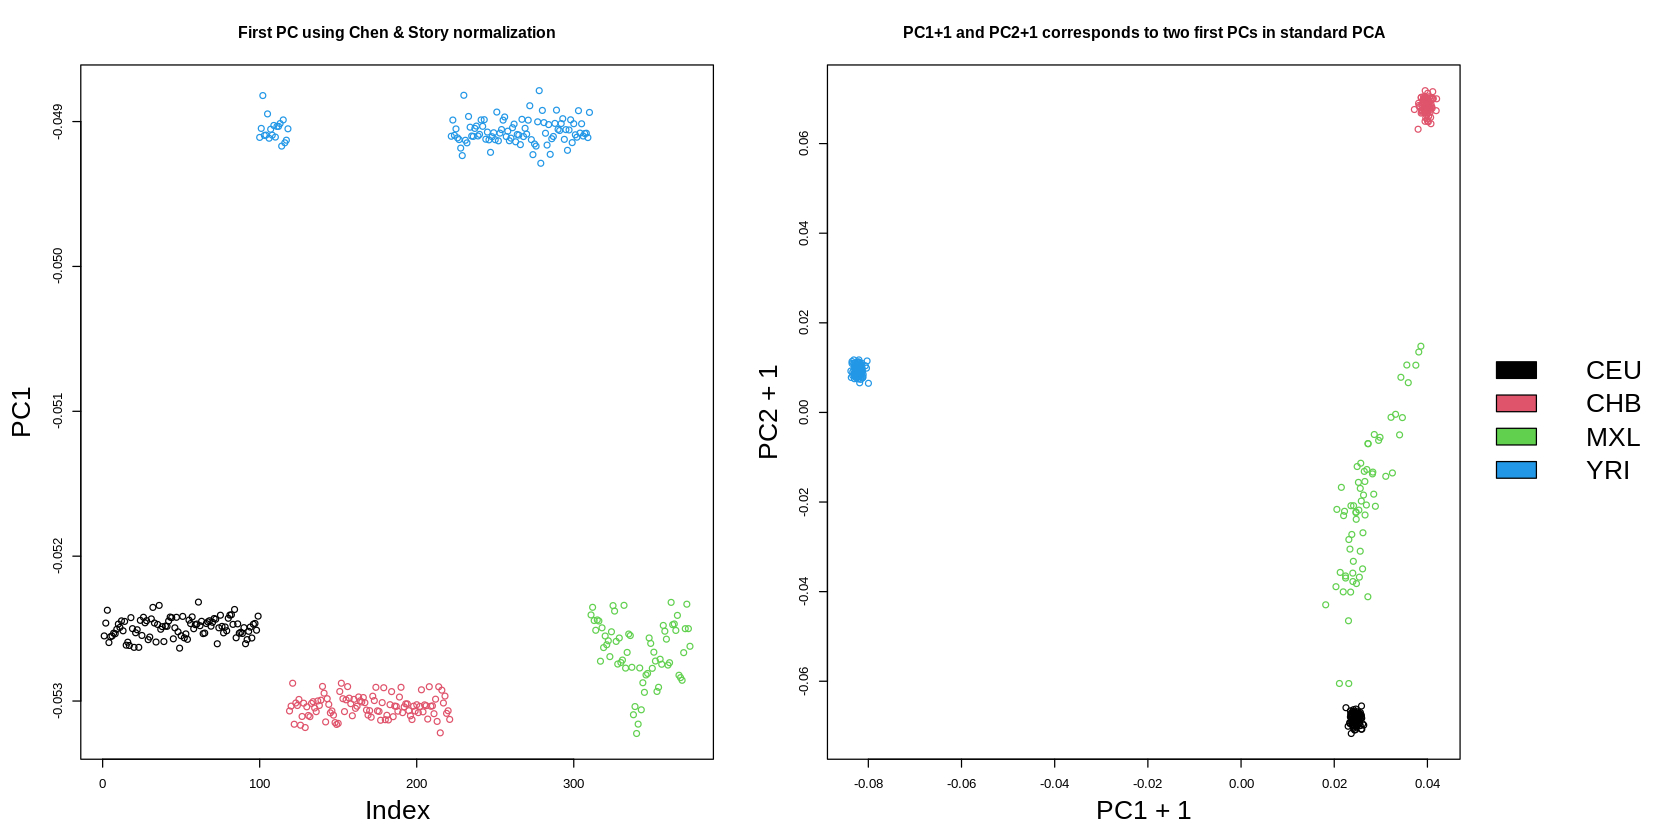

In [ ]:
layout(matrix(1:3,1),w=c(4,4,1))
options(repr.plot.width=14, repr.plot.height=7)


# for the chen and story PCA the first PC is different then standard PCA used in genentics
par(mar=c(5.1,5.1,4.1,2.1))
plot(e$vectors[,1],ylab="PC1",col=pop,cex.lab=2,main="First PC using Chen & Story normalization")
plot(e$vectors[,2:3],col=pop,xlab="PC1 + 1",ylab="PC2 + 1",cex.lab=2,main="PC1+1 and PC2+1 corresponds to two first PCs in standard PCA")

#plot legend
par(mar=c(0,0,0,0))
plot.new()
legend("center",fill=1:4,levels(pop),cex=2,bty="n")


In the visulazation the mexican population appears to be a mixture of European ( CEU ) and and chinese (CHB). However, this is due to their ancestry being both european and native american with the chinese individual being a proxy for their native american ancestry. 

We can try to evaluate the PCA using to correlation of residuals of the first 3 principal components. 
First we calculate the projection matrix for the first $k=3$ PCs
$$\widehat P_{1:k}= U_{1:k}(U_{1:k}^TU_{1:k})^{-1}U_{1:k}^T=U_{1:k}U_{1:k}^T.$$ 
The projection matrix is simply the matrix used to approximate/reduce the dimension of the data based on the first $k$ PCs
$$ G = UΣU^T \approx U_{1:k}Σ_{1:k,1:k}U_{1:k}^T = G \widehat P_{1:k}.$$
In other word the individual allele frequency which is the 2 times the predicted genotype value based in the first k PCs is $$G \widehat P_{1:k} =2\widehat \Pi \qquad with \qquad G_{si}\sim binomial(2,\Pi).$$ 


The difference between the observed and predicted value of the genotypes is

$$R_{1:k}=G-2 \widehat \Pi=G(I-\widehat P_{1:k}),$$

with *emperical* covariance and correlation of residuals 
$$\widehat B_{ij}=\frac 1{m-1}\sum_{s=1}^M (R_{1:k,si}-{\bar R}_{1:k,i} )(R_{1:k,sj}-{\bar R}_{1:k,j})
, \quad 
 and \quad
\widehat b_{ij}=\frac{\widehat B_{ij}}{\sqrt{\widehat B_{ii}\widehat B_{jj}}},$$
where ${\bar R}_{1:k,i} = \frac1m \sum_{s=1}^M R_{1:k,si}$.


The estimated coveriance and correlatoin matrix under the admixture model is 
$$\widehat C = (I-\widehat P_{1:k})\widehat D(I-\widehat P_{1:k})\quad and \quad
\widehat c_{ij} = \frac{\widehat C_{ij}}{\sqrt{\widehat C_{ii}\widehat C_{jj}}}.
$$. 

We correct the emerical correlation matrix with the estimated one under the admixture model $\widehat b- \widehat c$ and plot it. The matrix is symetric and instead of plotting the indivudals pairs in the lower triangle we instead take the mean accross pairs within/between polations

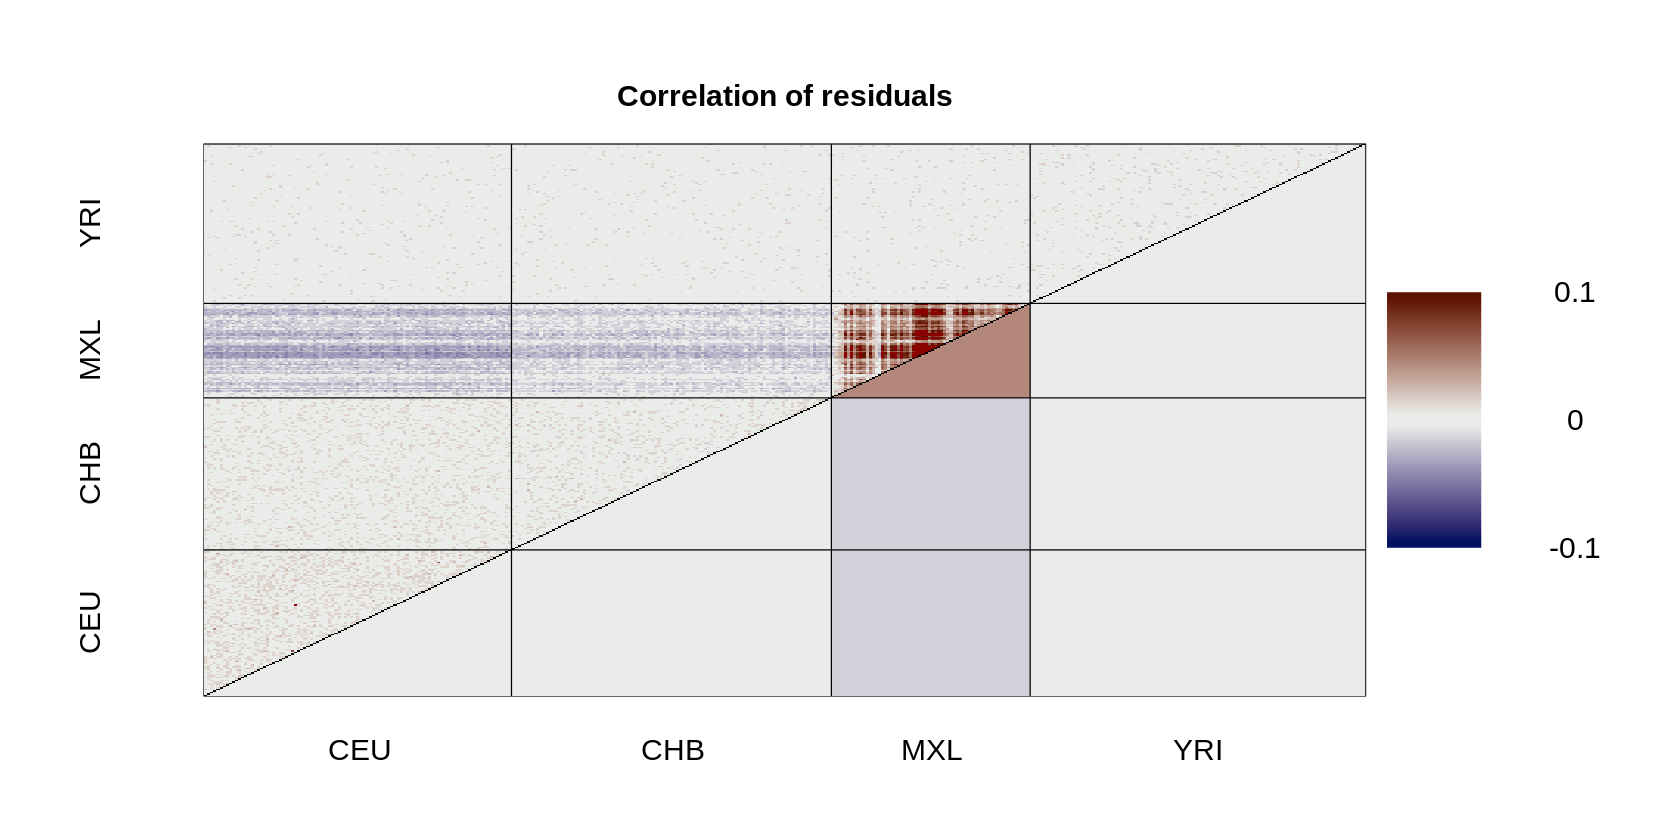

In [ ]:
k <- 2+1
phatk <- e$vectors[,1:k] %*% t(e$vectors[,1:k])

# emperical correlation of residuals
rk <- g %*% (diag(N) - phatk)
bhat <- cor(rk)

## estimated correlattion matrix assuming the admixture model
covHat <- (diag(N) - phatk) %*% D_hat %*% (diag(N) - phatk)
chat <- cov2cor(covHat)


#emerical correlation adjusted for the estimated correlation from the admixture model
corres <- bhat - chat

#plot the difference in correlation 
plotCorRes(corres, pop,max=0.1)




The upper triangle is the corrected correlation between idnividauls while the lower triangle is the mean corrected correlation within and between populations. 

As can be seen many of the MXL have a high residual correlation within 
population and negative between populations. This suggests that the MXL are more similar between each other than suggested by the PCA plot above. This is because the PCA with k=3 models the MXL as a mixture between CEU and CHB. 


## which individuals have a bad fit

We can try to show which individual have a bad fit by identifying individuals that have a high correlation with one or more individuals. This is shown below

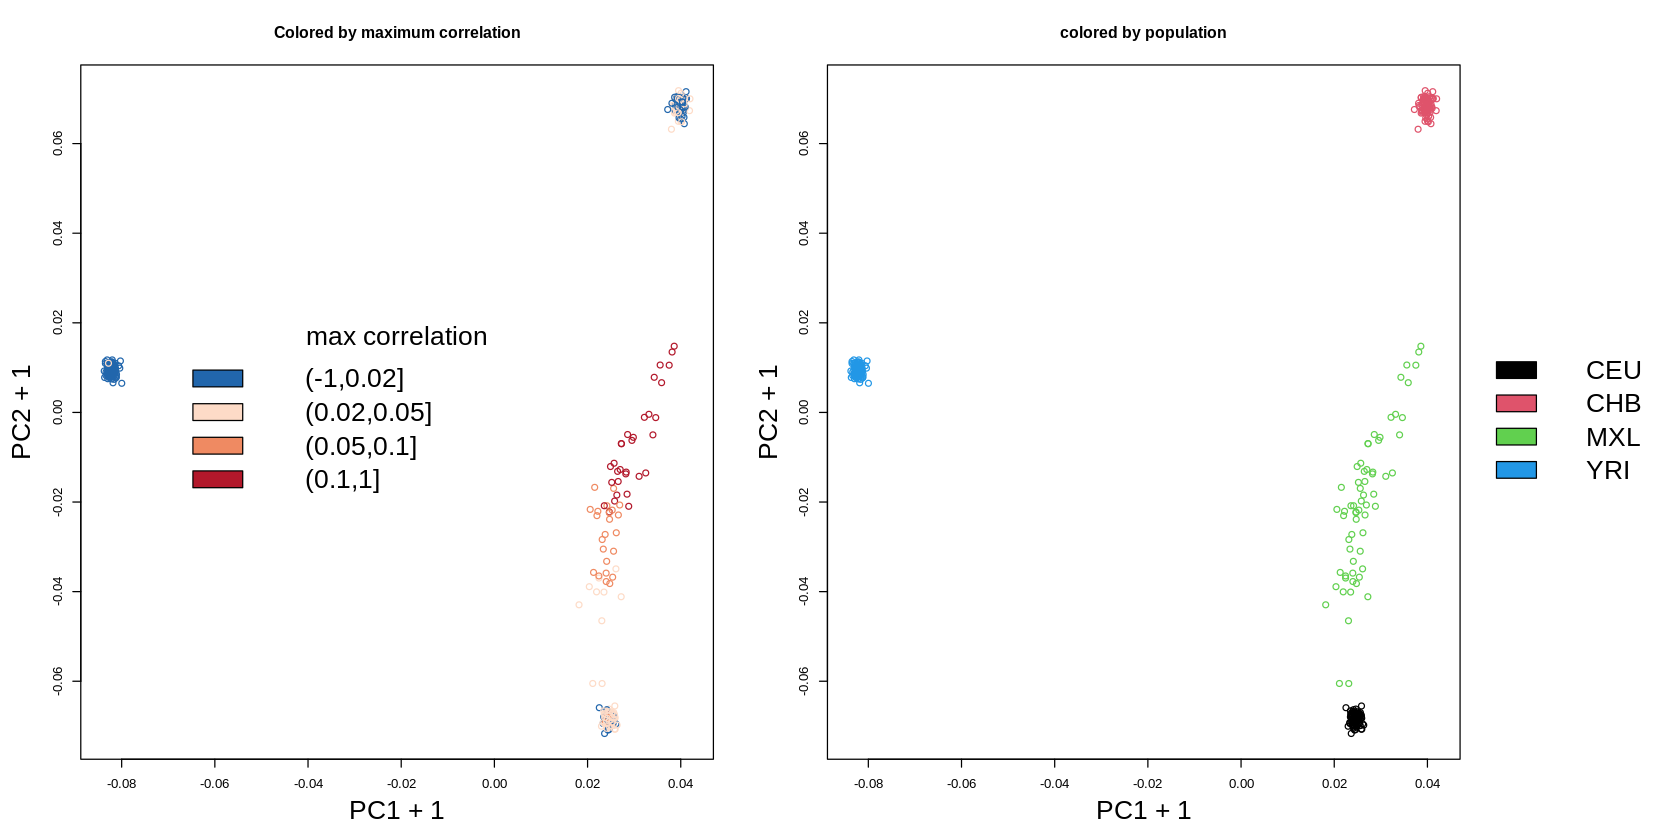

In [ ]:

layout(matrix(1:3,1),w=c(4,4,1))
options(repr.plot.width=14, repr.plot.height=7)


#color individuals by their maximum correlation
eval <- corres
diag(eval) <- 0
maxCor <- apply(eval,1,max)
redBlue <- c("#2166ac","#fddbc7","#ef8a62","#b2182b")
coll <- cut( maxCor ,c(-1,0.02,0.05,0.1,1))


# show the maximum correlation in the plot
par(mar=c(5.1,5.1,4.1,2.1))
#plot(e$vectors[,2:3],col="black",xlab="PC2",ylab="PC3",cex.lab=2,main="Chen and Story (PCA1)")
plot(e$vectors[,1:2+1],main="Colored by maximum correlation",xlab="PC1 + 1",ylab="PC2 + 1",col=redBlue[coll],cex.lab=2)
legend("center",fill=redBlue,title="max correlation",levels(coll),cex=2,bty="n")

## PCA plto
plot(e$vectors[,2:3],col=pop,xlab="PC1 + 1",ylab="PC2 + 1",cex.lab=2,main="colored by population")

#plot legend
par(mar=c(0,0,0,0))
plot.new()
legend("center",fill=1:4,levels(pop),cex=2,bty="n")


## Adding another dimension

Instead of using 2 PCs to model the population structure we can try to use 3. In this way we can allow for the native american ancestry to have its own ancestral allele frequency instead of being model togeather with the chinese. 

The PCA will look like this

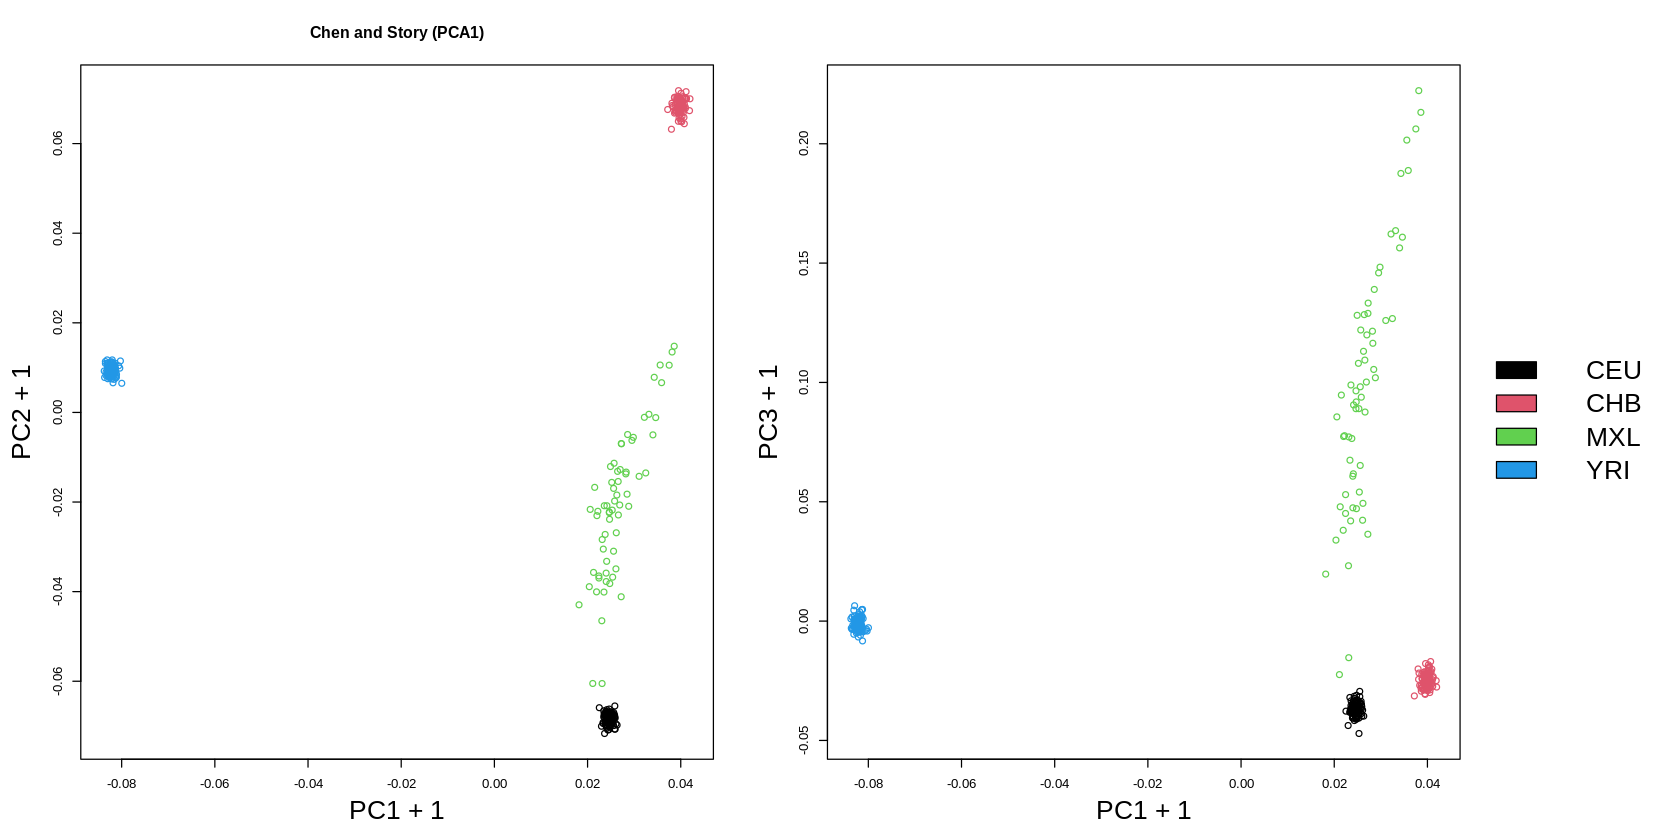

In [ ]:
layout(matrix(1:3,1),w=c(4,4,1))
options(repr.plot.width=14, repr.plot.height=7)


# for the chen and story PCA the first PC is different then standard PCA used in genentics
par(mar=c(5.1,5.1,4.1,2.1))
plot(e$vectors[,2:3],col=pop,xlab="PC1 + 1",ylab="PC2 + 1",cex.lab=2,main="Chen and Story (PCA1)")
plot(e$vectors[,c(2,4)],ylab="PC3 + 1" ,xlab="PC1 + 1",col=pop,cex.lab=2)

#plot legend
par(mar=c(0,0,0,0))
plot.new()
legend("center",fill=1:4,levels(pop),cex=2,bty="n")


The new PC ( PC 3+1) now shows that the MXL have some ancestry that is not a mixture of the CEU and  CHB and the correlation of residuals is now low:

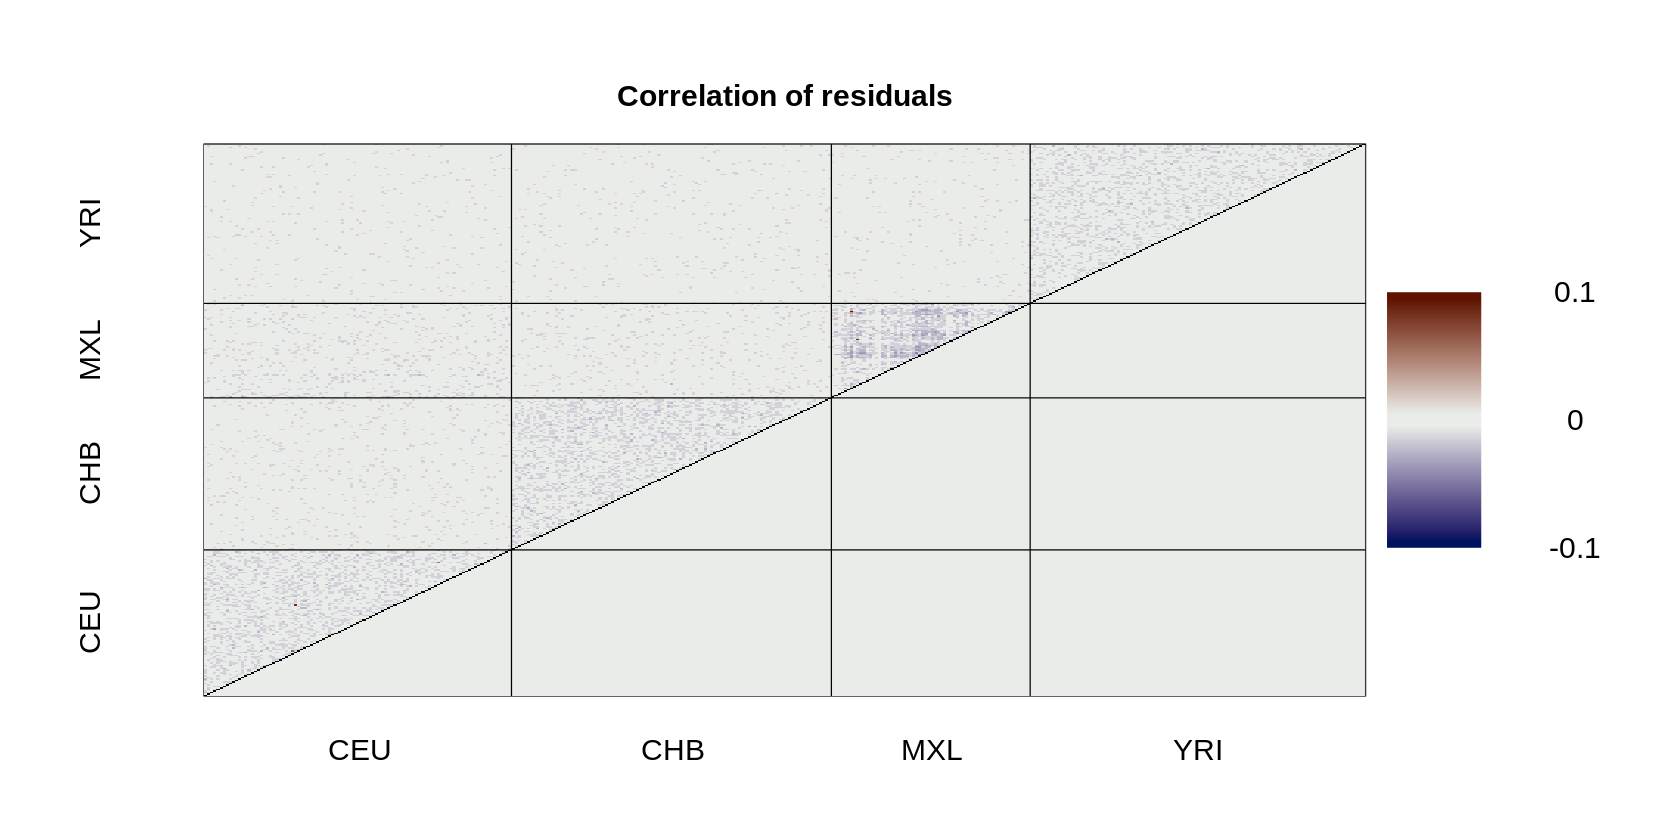

In [ ]:
k<- 3+1
phatk <- e$vectors[,1:k] %*% t(e$vectors[,1:k])

# emperical correlation of residuals
rk <- g %*% (diag(N) - phatk)
bhat <- cor(rk)

## estimated correlattion matrix assuming the admixture model
chat <- (diag(N) - phatk) %*% D_hat %*% (diag(N) - phatk)

#difference between emerical and estimated
corres <- bhat - chat

#plot the difference in correlation 
plotCorRes(corres, pop,max=0.1)


# conclusion

 - Using only 2(+1) PCs to visualize the population structure for CEU,MXL,CEU and YRI can be misleading
 - with 2(+1) PCs some MXL appears to be admixed between CEU(european) and CHB(chinese) 
 -- However, the correlation of residuals shows that these individual have a bad fit
 - Using 3(+1) PCs shows that the MXL indiviudal are modeled using this extra PC and with that extra PC they no longer show a bad fit